In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Reshape, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_probability as tfp

# for SNGP
import gpflow
import gpflux
from gpflow.config import default_float
from lib.spectral_normalization import SpectralNormalization

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae

from os import listdir
from os.path import isfile, join
from tqdm import tqdm


plt.rcParams.update({'font.size': 18})

In [2]:
mypath = 'N-CMAPSS_DL/N-CMAPSS/Samples_whole/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

train_units = [2,5,10,16,18,20]
test_units = [11,14,15]

test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
train_files = list(set(onlyfiles) - set(test_files))
print(train_files)

['Unit5_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz', 'Unit16_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz', 'Unit20_win1_str1_smp500.npz', 'Unit11_win1_str1_smp500.npz', 'Unit14_win1_str1_smp500.npz', 'Unit15_win1_str1_smp500.npz']
['Unit5_win1_str1_smp500.npz', 'Unit16_win1_str1_smp500.npz', 'Unit20_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz']


In [3]:
def load_part_array_merge (current_dir, npz_units):
    sample_array_lst = []
    label_array_lst = []
    for npz_unit in npz_units:
      loaded = np.load(current_dir + npz_unit)
      sample_array_lst.append(loaded['sample'])
      label_array_lst.append(loaded['label'])
    sample_array = np.dstack(sample_array_lst)
    label_array = np.concatenate(label_array_lst)
    sample_array = sample_array.transpose(2, 0, 1)
    return sample_array, label_array

In [4]:
Xtrain_norm,Ytrain = load_part_array_merge(mypath,train_files)
Xtest_norm,Ytest = load_part_array_merge(mypath,test_files)
print(Xtrain_norm.shape)
Xtrain_norm = Xtrain_norm[:,0,:]
Xtest_norm = Xtest_norm[:,0,:]
Ytrain_norm = np.expand_dims((Ytrain)/np.max(Ytrain),1)
#Ytrain_norm = (Ytrain)/np.max(Ytrain)
Ytest_norm = np.expand_dims((Ytest)/np.max(Ytrain),1)
#Ytest_norm = (Ytest)/np.max(Ytrain)

(10527, 1, 20)


In [5]:
test_units = [11]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest11_norm,Ytest11 = load_part_array_merge(mypath,test_files)
Xtest11_norm = Xtest11_norm[:,0,:]
Ytest11_norm = np.expand_dims((Ytest11)/np.max(Ytrain),1)


test_units = [14]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest14_norm,Ytest14 = load_part_array_merge(mypath,test_files)
Xtest14_norm = Xtest14_norm[:,0,:]
Ytest14_norm = np.expand_dims((Ytest14)/np.max(Ytrain),1)


test_units = [15]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest15_norm,Ytest15 = load_part_array_merge(mypath,test_files)
Xtest15_norm = Xtest15_norm[:,0,:]
Ytest15_norm = np.expand_dims((Ytest15)/np.max(Ytrain),1)

In [7]:
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    """
    Input: 
    y_true - true values
    mu     - predicted mean
    sigma  - predicted standard deviation
    
    Output:
    exp_CIs - expected confidence
    pred_CIs - predicted confidence
    """
    exp_CIs = np.linspace(1e-10, 1-1e-10, 1000)
    pred_CIs=[]
    for exp_CI in tqdm(sorted(exp_CIs)):
        intervals = scipy.stats.norm.interval(exp_CI, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        pred_CIs.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    ECE = np.mean(np.abs(exp_CIs - pred_CIs))
    return 100*exp_CIs, 100*np.array(pred_CIs), ECE*100  # converting to percentages

In [8]:
def generate_trained_SNGPmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    # define Gaussian layer
    num_data = len(trainX)
    num_inducing = 100
    output_dim = 1

    kernel = gpflow.kernels.SquaredExponential()
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.linspace(-1, 1, num_inducing).reshape(-1, 1)
    )
    gp_layer = gpflux.layers.GPLayer(
        kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim, mean_function = None
    )

    likelihood = gpflow.likelihoods.Gaussian(variance = 1)
    

    # So that Keras can track the likelihood variance, we need to provide the likelihood as part of a "dummy" layer:
    likelihood_container = gpflux.layers.TrackableLayer()
    likelihood_container.likelihood = likelihood

    # define model
    model = tf.keras.Sequential(
        [
            SpectralNormalization(Dense(100, activation=actfn), norm_multiplier=0.9),
            SpectralNormalization(Dense(10, activation=actfn), norm_multiplier=0.9),
            SpectralNormalization(Dense(1, activation=actfn), norm_multiplier=0.9),
            gp_layer,
            likelihood_container,  # no-op, for discovering trainable likelihood parameters
        ]
    )
    loss = gpflux.losses.LikelihoodLoss(likelihood)
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(loss=loss, optimizer=optimizer)
    hist= model.fit(trainX, trainY, epochs=nepochs, verbose=1)
    plt.plot(hist.history["loss"])
    return model

Epoch 1/5
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
329/329 [==============================] - 6s 5ms/step - loss: 0.9427 - gp_layer_prior_kl: 4.0729e-04
Epoch 2/5
329/329 [==============================] - 2s 5ms/step - loss: 0.7837 - gp_layer_prior_kl: 4.8851e-04
Epoch 3/5
329/329 [==============================] - 2s 5ms/step - loss: 0.6607 - gp_layer_prior_kl: 6.3623e-04
Epoch 4/5
329/329 [==============================] - 2s 5ms/step - loss: 0.5289 - gp_layer_prior_kl: 8.8783e-04
Epoch 5/5
329/329 [==============================] - 2s 5ms/step - loss: 0.3954 - gp_layer_prior_kl: 0.0011


100% |#######################################################################################################################################################################|


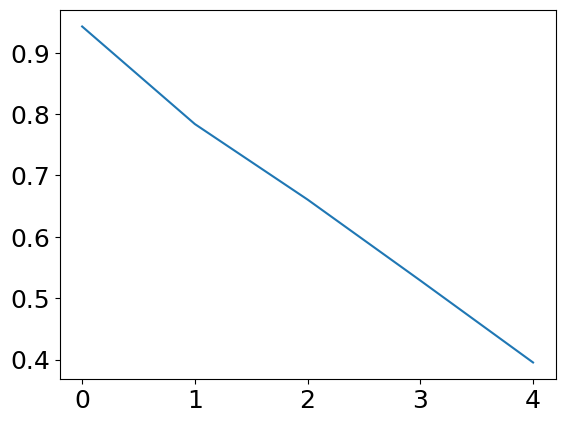

In [8]:
# Single run through
nmodels = 1 # train models and select the best out of these
all_models_SNGP=[]
all_mae_train_SNGP = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, 5, 'relu')
    f_distribution = model_SNGP(Xtrain_norm)
    mean = f_distribution.mean().numpy()*(np.max(Ytrain))
    all_mae_train_SNGP[i] = mae(mean, Ytrain)
    all_models_SNGP.append(model_SNGP)

In [9]:

select_modelSNGP = all_models_SNGP[np.argmin(all_mae_train_SNGP)]
print("Train MAE: ", mae(model_SNGP(Xtrain_norm).mean().numpy()*(np.max(Ytrain)), Ytrain))
print("Test11 MAE: ", mae(model_SNGP(Xtest11_norm).mean().numpy()*(np.max(Ytrain)), Ytest11))
print("Test14 MAE: ", mae(model_SNGP(Xtest14_norm).mean().numpy()*(np.max(Ytrain)), Ytest14))
print("Test15 MAE: ", mae(model_SNGP(Xtest15_norm).mean().numpy()*(np.max(Ytrain)), Ytest15))
print("Test MAE: ", mae(model_SNGP(Xtest_norm).mean().numpy()*(np.max(Ytrain)), Ytest))



Train MAE:  14.662985248484564
Test11 MAE:  11.5310608399522
Test14 MAE:  15.33278115562959
Test15 MAE:  12.30127998015059
Test MAE:  12.273293764064904


In [10]:
# single run
allresults_SNGPdf = pd.DataFrame()
dataset = ['train', 'test', 'test11', 'test14', 'test15']
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    result_df["SNGP_mu_eff"] = model_SNGP(Xnorm).mean().numpy()
    result_df["SNGP_sigma_eff"] = np.sqrt(model_SNGP(Xnorm).variance().numpy()
                                   +model_SNGP.layers[-1].likelihood.variance.numpy())

    allresults_SNGPdf = pd.concat([allresults_SNGPdf, result_df], axis = 0)

allresults_SNGPdf["SNGP_mu_eff"] = allresults_SNGPdf["SNGP_mu_eff"]*(np.max(Ytrain))
allresults_SNGPdf["SNGP_sigma_eff"] = allresults_SNGPdf["SNGP_sigma_eff"]*(np.max(Ytrain))

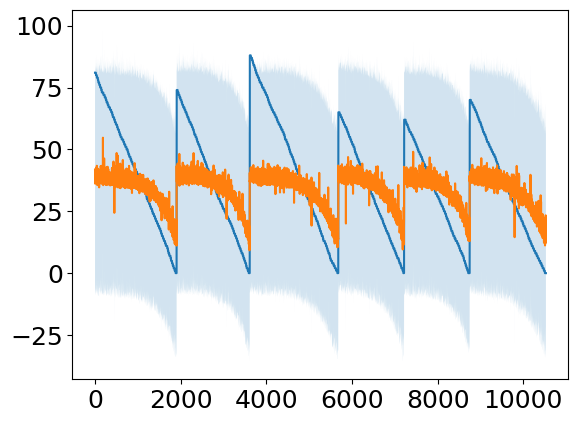

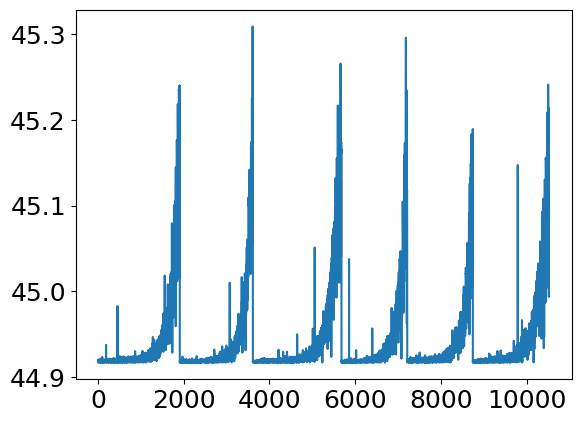

In [12]:
y_true = allresults_SNGPdf[allresults_SNGPdf['dataset']=='train']['True'].values
y_pred = allresults_SNGPdf[allresults_SNGPdf['dataset']=='train']['SNGP_mu_eff'].values
sigma_pred = allresults_SNGPdf[allresults_SNGPdf['dataset']=='train']['SNGP_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)


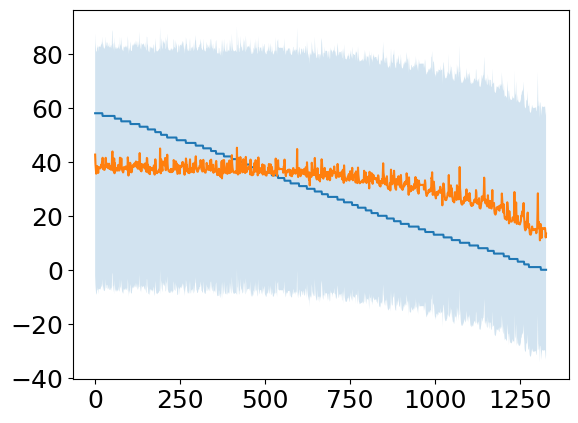

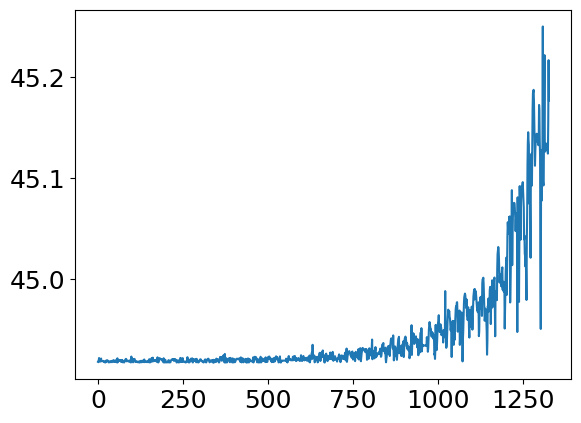

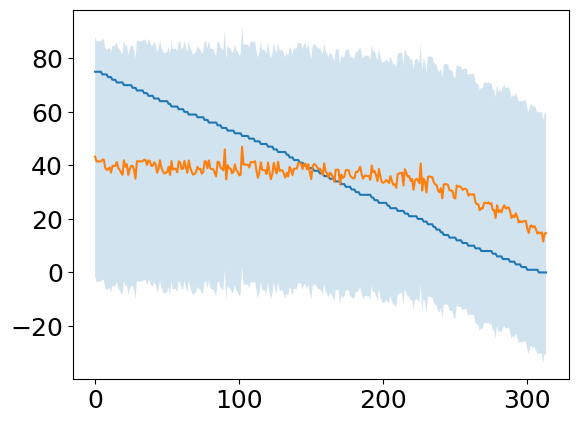

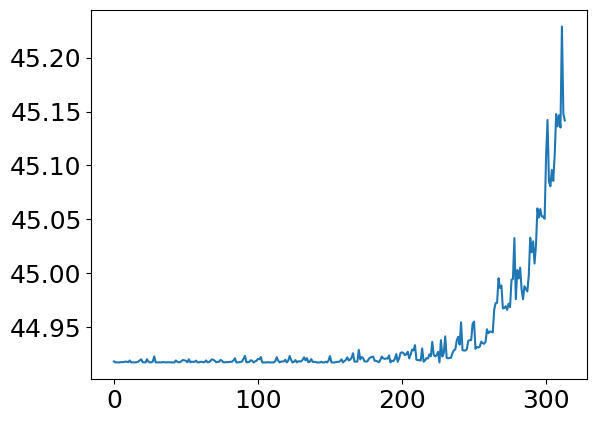

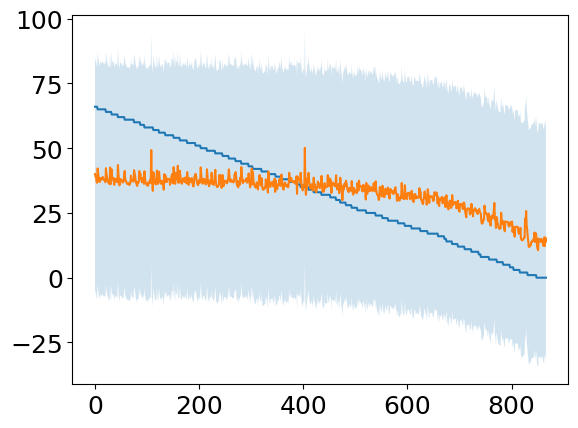

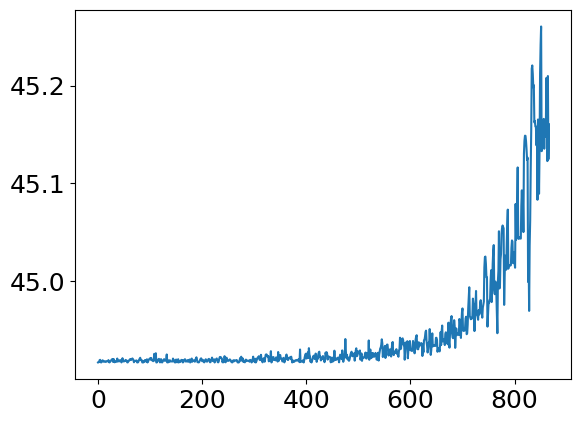

In [13]:
y_true = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test11']['True'].values
y_pred = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test11']['SNGP_mu_eff'].values
sigma_pred = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test11']['SNGP_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test14']['True'].values
y_pred = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test14']['SNGP_mu_eff'].values
sigma_pred = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test14']['SNGP_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test15']['True'].values
y_pred = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test15']['SNGP_mu_eff'].values
sigma_pred = allresults_SNGPdf[allresults_SNGPdf['dataset']=='test15']['SNGP_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 688.43it/s]


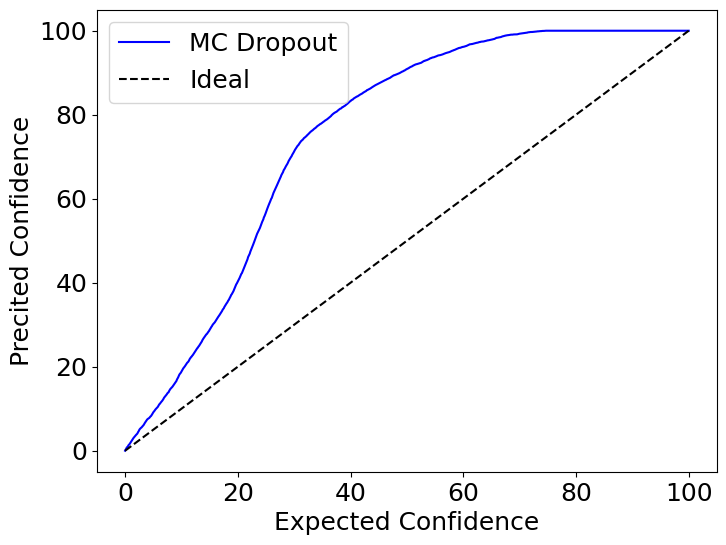

In [14]:
# plot the calibration curve
allresults_SNGPdf_train = allresults_SNGPdf.loc[allresults_SNGPdf['dataset']=='train']

alphas, CI_DE,_ = get_confidence_interval(allresults_SNGPdf_train['True'].values, 
                                       allresults_SNGPdf_train['SNGP_mu_eff'].values, 
                                       allresults_SNGPdf_train['SNGP_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

Epoch 1/100
329/329 [==============================] - 4s 5ms/step - loss: 0.9380 - gp_layer_6_prior_kl: 4.1201e-04
Epoch 2/100
329/329 [==============================] - 2s 5ms/step - loss: 0.7830 - gp_layer_6_prior_kl: 4.9216e-04
Epoch 3/100
329/329 [==============================] - 2s 5ms/step - loss: 0.6585 - gp_layer_6_prior_kl: 6.6948e-04
Epoch 4/100
329/329 [==============================] - 2s 5ms/step - loss: 0.5277 - gp_layer_6_prior_kl: 9.7123e-04
Epoch 5/100
329/329 [==============================] - 2s 5ms/step - loss: 0.3931 - gp_layer_6_prior_kl: 0.0012
Epoch 6/100
329/329 [==============================] - 2s 5ms/step - loss: 0.2575 - gp_layer_6_prior_kl: 0.0013
Epoch 7/100
329/329 [==============================] - 2s 5ms/step - loss: 0.1282 - gp_layer_6_prior_kl: 0.0014
Epoch 8/100
329/329 [==============================] - 2s 5ms/step - loss: -7.1116e-04 - gp_layer_6_prior_kl: 0.0015
Epoch 9/100
329/329 [==============================] - 2s 5ms/step - loss: -0.1014 

Epoch 44/100
329/329 [==============================] - 1s 5ms/step - loss: -0.5834 - gp_layer_7_prior_kl: 0.0024
Epoch 45/100
329/329 [==============================] - 1s 4ms/step - loss: -0.6063 - gp_layer_7_prior_kl: 0.0024
Epoch 46/100
329/329 [==============================] - 1s 4ms/step - loss: -0.6252 - gp_layer_7_prior_kl: 0.0025
Epoch 47/100
329/329 [==============================] - 1s 4ms/step - loss: -0.6429 - gp_layer_7_prior_kl: 0.0025
Epoch 48/100
329/329 [==============================] - 1s 4ms/step - loss: -0.6142 - gp_layer_7_prior_kl: 0.0025
Epoch 49/100
329/329 [==============================] - 1s 4ms/step - loss: -0.6147 - gp_layer_7_prior_kl: 0.0025
Epoch 50/100
329/329 [==============================] - 1s 4ms/step - loss: -0.6407 - gp_layer_7_prior_kl: 0.0025
Epoch 51/100
329/329 [==============================] - 1s 4ms/step - loss: -0.5978 - gp_layer_7_prior_kl: 0.0025
Epoch 52/100
329/329 [==============================] - 1s 4ms/step - loss: -0.6314 - gp

Epoch 1/100
329/329 [==============================] - 4s 5ms/step - loss: 0.9343 - gp_layer_8_prior_kl: 4.1631e-04
Epoch 2/100
329/329 [==============================] - 2s 5ms/step - loss: 0.7816 - gp_layer_8_prior_kl: 4.9450e-04
Epoch 3/100
329/329 [==============================] - 2s 5ms/step - loss: 0.6573 - gp_layer_8_prior_kl: 7.1176e-04
Epoch 4/100
329/329 [==============================] - 2s 5ms/step - loss: 0.5257 - gp_layer_8_prior_kl: 0.0010
Epoch 5/100
329/329 [==============================] - 2s 5ms/step - loss: 0.3899 - gp_layer_8_prior_kl: 0.0012
Epoch 6/100
329/329 [==============================] - 2s 5ms/step - loss: 0.2571 - gp_layer_8_prior_kl: 0.0013
Epoch 7/100
329/329 [==============================] - 2s 5ms/step - loss: 0.1245 - gp_layer_8_prior_kl: 0.0014
Epoch 8/100
329/329 [==============================] - 2s 5ms/step - loss: -0.0082 - gp_layer_8_prior_kl: 0.0015
Epoch 9/100
329/329 [==============================] - 2s 5ms/step - loss: -0.1232 - gp_lay

Epoch 44/100
329/329 [==============================] - 2s 5ms/step - loss: -0.5962 - gp_layer_9_prior_kl: 0.0024
Epoch 45/100
329/329 [==============================] - 2s 5ms/step - loss: -0.5804 - gp_layer_9_prior_kl: 0.0024
Epoch 46/100
329/329 [==============================] - 2s 5ms/step - loss: -0.6190 - gp_layer_9_prior_kl: 0.0024
Epoch 47/100
329/329 [==============================] - 2s 5ms/step - loss: -0.6333 - gp_layer_9_prior_kl: 0.0024
Epoch 48/100
329/329 [==============================] - 2s 5ms/step - loss: -0.6199 - gp_layer_9_prior_kl: 0.0024
Epoch 49/100
329/329 [==============================] - 2s 5ms/step - loss: -0.5135 - gp_layer_9_prior_kl: 0.0024
Epoch 50/100
329/329 [==============================] - 2s 5ms/step - loss: -0.6116 - gp_layer_9_prior_kl: 0.0024
Epoch 51/100
329/329 [==============================] - 2s 5ms/step - loss: -0.5843 - gp_layer_9_prior_kl: 0.0024
Epoch 52/100
329/329 [==============================] - 2s 5ms/step - loss: -0.6111 - gp

Epoch 1/100
329/329 [==============================] - 4s 4ms/step - loss: 0.9429 - gp_layer_10_prior_kl: 4.1241e-04
Epoch 2/100
329/329 [==============================] - 1s 5ms/step - loss: 0.7837 - gp_layer_10_prior_kl: 4.7846e-04
Epoch 3/100
329/329 [==============================] - 1s 4ms/step - loss: 0.6614 - gp_layer_10_prior_kl: 6.3384e-04
Epoch 4/100
329/329 [==============================] - 2s 5ms/step - loss: 0.5293 - gp_layer_10_prior_kl: 9.0369e-04
Epoch 5/100
329/329 [==============================] - 1s 4ms/step - loss: 0.3939 - gp_layer_10_prior_kl: 0.0011
Epoch 6/100
329/329 [==============================] - 1s 4ms/step - loss: 0.2574 - gp_layer_10_prior_kl: 0.0013
Epoch 7/100
329/329 [==============================] - 1s 4ms/step - loss: 0.1224 - gp_layer_10_prior_kl: 0.0014
Epoch 8/100
329/329 [==============================] - 1s 4ms/step - loss: -0.0030 - gp_layer_10_prior_kl: 0.0015
Epoch 9/100
329/329 [==============================] - 2s 5ms/step - loss: -0.1

329/329 [==============================] - 2s 5ms/step - loss: 0.0505 - gp_layer_11_prior_kl: 5.4072e-04
Epoch 43/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0504 - gp_layer_11_prior_kl: 5.4019e-04
Epoch 44/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0508 - gp_layer_11_prior_kl: 5.4013e-04
Epoch 45/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0509 - gp_layer_11_prior_kl: 5.4014e-04
Epoch 46/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0509 - gp_layer_11_prior_kl: 5.3930e-04
Epoch 47/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0507 - gp_layer_11_prior_kl: 5.3954e-04
Epoch 48/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0508 - gp_layer_11_prior_kl: 5.3907e-04
Epoch 49/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0507 - gp_layer_11_prior_kl: 5.3917e-04
Epoch 50/100
329/329 [==============================] - 2s 5ms/step -

Epoch 1/100
329/329 [==============================] - 4s 5ms/step - loss: 0.9742 - gp_layer_12_prior_kl: 4.9773e-04
Epoch 2/100
329/329 [==============================] - 2s 5ms/step - loss: 0.7797 - gp_layer_12_prior_kl: 5.3861e-04
Epoch 3/100
329/329 [==============================] - 2s 5ms/step - loss: 0.6605 - gp_layer_12_prior_kl: 5.2169e-04
Epoch 4/100
329/329 [==============================] - 2s 5ms/step - loss: 0.5404 - gp_layer_12_prior_kl: 5.1888e-04
Epoch 5/100
329/329 [==============================] - 2s 5ms/step - loss: 0.4254 - gp_layer_12_prior_kl: 5.3061e-04
Epoch 6/100
329/329 [==============================] - 2s 5ms/step - loss: 0.3169 - gp_layer_12_prior_kl: 5.3924e-04
Epoch 7/100
329/329 [==============================] - 2s 5ms/step - loss: 0.2248 - gp_layer_12_prior_kl: 5.4666e-04
Epoch 8/100
329/329 [==============================] - 2s 5ms/step - loss: 0.1531 - gp_layer_12_prior_kl: 5.5547e-04
Epoch 9/100
329/329 [==============================] - 2s 5ms/st

329/329 [==============================] - 1s 5ms/step - loss: 0.0510 - gp_layer_13_prior_kl: 5.4189e-04
Epoch 40/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0510 - gp_layer_13_prior_kl: 5.4182e-04
Epoch 41/100
329/329 [==============================] - 1s 4ms/step - loss: 0.0506 - gp_layer_13_prior_kl: 5.4151e-04
Epoch 42/100
329/329 [==============================] - 1s 5ms/step - loss: 0.0508 - gp_layer_13_prior_kl: 5.4127e-04
Epoch 43/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0505 - gp_layer_13_prior_kl: 5.4085e-04
Epoch 44/100
329/329 [==============================] - 1s 4ms/step - loss: 0.0505 - gp_layer_13_prior_kl: 5.4070e-04
Epoch 45/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0516 - gp_layer_13_prior_kl: 5.4013e-04
Epoch 46/100
329/329 [==============================] - 1s 5ms/step - loss: 0.0503 - gp_layer_13_prior_kl: 5.4009e-04
Epoch 47/100
329/329 [==============================] - 2s 5ms/step -

Epoch 1/100
329/329 [==============================] - 4s 4ms/step - loss: 0.9540 - gp_layer_14_prior_kl: 4.0537e-04
Epoch 2/100
329/329 [==============================] - 1s 5ms/step - loss: 0.7831 - gp_layer_14_prior_kl: 4.7094e-04
Epoch 3/100
329/329 [==============================] - 1s 5ms/step - loss: 0.6597 - gp_layer_14_prior_kl: 5.5777e-04
Epoch 4/100
329/329 [==============================] - 1s 5ms/step - loss: 0.5305 - gp_layer_14_prior_kl: 8.1096e-04
Epoch 5/100
329/329 [==============================] - 1s 5ms/step - loss: 0.3948 - gp_layer_14_prior_kl: 0.0010
Epoch 6/100
329/329 [==============================] - 1s 4ms/step - loss: 0.2643 - gp_layer_14_prior_kl: 0.0012
Epoch 7/100
329/329 [==============================] - 1s 4ms/step - loss: 0.1279 - gp_layer_14_prior_kl: 0.0013
Epoch 8/100
329/329 [==============================] - 1s 4ms/step - loss: 5.4937e-04 - gp_layer_14_prior_kl: 0.0015
Epoch 9/100
329/329 [==============================] - 2s 5ms/step - loss: -

329/329 [==============================] - 1s 5ms/step - loss: 0.0507 - gp_layer_15_prior_kl: 5.4078e-04
Epoch 43/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0511 - gp_layer_15_prior_kl: 5.4039e-04
Epoch 44/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0508 - gp_layer_15_prior_kl: 5.4012e-04
Epoch 45/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0508 - gp_layer_15_prior_kl: 5.4010e-04
Epoch 46/100
329/329 [==============================] - 1s 5ms/step - loss: 0.0507 - gp_layer_15_prior_kl: 5.3969e-04
Epoch 47/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0506 - gp_layer_15_prior_kl: 5.3960e-04
Epoch 48/100
329/329 [==============================] - 2s 5ms/step - loss: 0.0510 - gp_layer_15_prior_kl: 5.3930e-04
Epoch 49/100
329/329 [==============================] - 1s 5ms/step - loss: 0.0509 - gp_layer_15_prior_kl: 5.3903e-04
Epoch 50/100
329/329 [==============================] - 2s 5ms/step -

100% |####################################################################################################################################################################|


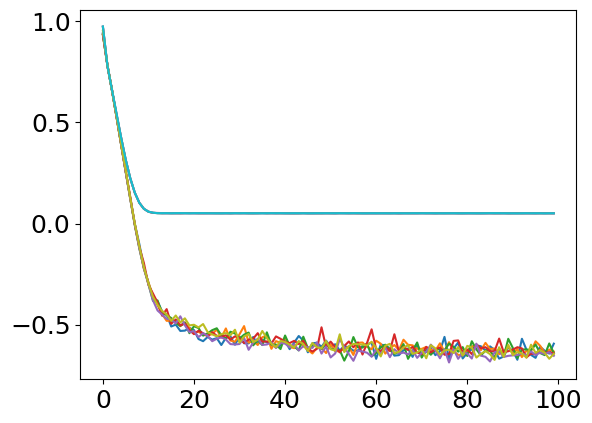

In [15]:
dataset = ['train', 'test', 'test11', 'test14', 'test15']
nmodels = 2 # total models trained and best one picked
niter = 5

allCI_SNGP = np.zeros((1000, niter))
pbar=ProgressBar()
allresults_SNGPdf = pd.DataFrame()

for myiter in pbar(range(niter)): # for each independent iteration
    all_models_SNGP=[]
    all_mae_train_SNGP = np.zeros(nmodels,)
    for i in range(nmodels): # train multiple models to select the best
        model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, 100, 'relu')
        f_distribution = model_SNGP(Xtrain_norm)
        mean = f_distribution.mean().numpy()*(np.max(Ytrain))
        all_mae_train_SNGP[i] = mae(mean, Ytrain)
        all_models_SNGP.append(model_SNGP)

    select_modelSNGP = all_models_SNGP[np.argmin(all_mae_train_SNGP)] # best model

    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        result_df["SNGP_mu_eff"] = select_modelSNGP(Xnorm).mean().numpy()*(np.max(Ytrain))
        result_df["SNGP_sigma_eff"] = np.sqrt(select_modelSNGP(Xnorm).variance().numpy() + 
                                       select_modelSNGP.layers[-1].likelihood.variance.numpy())*(np.max(Ytrain))
        result_df['iteration'] = myiter
        allresults_SNGPdf = pd.concat([allresults_SNGPdf, result_df], axis = 0)

allresults_SNGPdf.to_excel("results/SNGP_CMAPPS_results.xlsx")  
